In [1]:
%load_ext autoreload
%autoreload 2
from taigapy import TaigaClient
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from cds import plotting
from mgenepy.utils import helper
from taigapy import create_taiga_client_v3
from scipy.stats import pearsonr
from sklearn.decomposition import FastICA
tc = TaigaClient()

# Load dataset

In [2]:
%%capture

OmicsExpressionAllGenesEffectiveLengthProfile = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionAllGenesEffectiveLengthProfile')
OmicsExpressionAllGenesTPMLogp1Profile = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionAllGenesTPMLogp1Profile')
OmicsExpressionGenesExpectedCountProfile = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionGenesExpectedCountProfile')
OmicsDefaultModelProfiles = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsDefaultModelProfiles')
OmicsDefaultModelConditionProfiles = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsDefaultModelConditionProfiles')

In [3]:
OmicsExpressionProteinCodingGenesTPMLogp1 = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionProteinCodingGenesTPMLogp1')

In [4]:
tc = create_taiga_client_v3()
df_gene_effect = tc.get('internal-23q4-ac2b.68/CRISPRGeneEffect')

# Calculate raw TPM

In [5]:
def calculate_tpm(counts_df, transcripts_length_df):
    """https://github.com/deweylab/RSEM/blob/8bc1e2115493c0cdf3c6bee80ef7a21a91b2acce/WriteResults.h#L77"""
    assert counts_df.shape == transcripts_length_df.shape

    denom = counts_df.sum(axis=1)
    denom = denom.where(denom > 1e-300, 1)
    print(denom.isnull().sum().sum())
    frac = counts_df.div(denom, axis=0)
    print(frac.isnull().sum().sum())

    transcripts_length_df = transcripts_length_df.where(transcripts_length_df > 1e-300, 1)
    fpkm = frac * 1e9 / transcripts_length_df
    print(fpkm.isnull().sum().sum())

    fpkm_sum = fpkm.sum(axis=1)
    fpkm_denom = fpkm_sum.where(fpkm_sum > 1e-300, 1)
    print(fpkm_denom.isnull().sum().sum())

    tpm_df = (fpkm.div(fpkm_denom, axis=0)) * 1e6
    print(tpm_df.isnull().sum().sum())
    return tpm_df

In [6]:
profile_to_model_dict = OmicsDefaultModelProfiles.query("ProfileType == 'rna'").\
        set_index("ProfileID").\
        drop("ProfileType", axis=1).\
        to_dict()["ModelID"]

In [7]:
mybiomart = helper.generateGeneNames(ensemble_server="http://nov2020.archive.ensembl.org/biomart", useCache=False)
protcod_rename = {}
for _, i in mybiomart[
    (~mybiomart.entrezgene_id.isna()) & (mybiomart.gene_biotype == "protein_coding")
].iterrows():
    if i.ensembl_gene_id not in protcod_rename:
        protcod_rename.update(
            {
                i.hgnc_symbol + " (" + i.ensembl_gene_id + ")": i.hgnc_symbol
                + " ("
                + str(int(i.entrezgene_id))
                + ")"
            }
        )

downloading gene names from biomart


In [8]:
OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes = OmicsExpressionAllGenesEffectiveLengthProfile.loc[:, OmicsExpressionGenesExpectedCountProfile.columns]

In [9]:
expected_counts = OmicsExpressionGenesExpectedCountProfile
expected_counts.columns = OmicsExpressionGenesExpectedCountProfile.columns.map(protcod_rename)
expected_counts = expected_counts.loc[:, ~expected_counts.columns.isnull()]

In [10]:
effected_len = OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes
effected_len.columns = OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes.columns.map(protcod_rename)
effected_len = effected_len.loc[:, ~effected_len.columns.isnull()]

In [11]:
expected_counts.shape, effected_len.shape

((1904, 19193), (1904, 19193))

In [12]:
raw_tpm = calculate_tpm(expected_counts, effected_len)

0
0
0
0
0


In [13]:
raw_tpm.loc[:, "Model"] = raw_tpm.index.map(profile_to_model_dict)
raw_tpm = raw_tpm.set_index("Model")
raw_tpm = raw_tpm.loc[OmicsExpressionProteinCodingGenesTPMLogp1.index, :]

In [14]:
raw_tpm.head()

,TSPAN6 (7105),TNMD (64102),DPM1 (8813),SCYL3 (57147),C1orf112 (55732),FGR (2268),CFH (3075),FUCA2 (2519),GCLC (2729),NFYA (4800),...,H3C2 (8358),H3C3 (8352),AC098582.1 (8916),DUS4L-BCAP29 (115253422),C8orf44-SGK3 (100533105),ELOA3B (728929),NPBWR1 (2831),ELOA3D (100506888),ELOA3 (162699),CDR1 (1038)
ACH-001113,20.526962,0.000000,175.666728,6.360556,22.709076,0.022054,1.441308,7.770455,95.985117,27.586337,...,5.842860,0.146074,0.159985,3.627486,0.506324,0.0,0.229611,0.0,0.0,0.000000
ACH-001289,23.742405,0.522378,143.074954,5.049324,10.821839,0.000000,0.146028,13.659763,18.462946,10.632261,...,1.502191,1.118475,0.256480,1.837610,0.574309,0.0,0.014282,0.0,0.0,0.000000
ACH-001339,8.149281,0.000000,171.193332,4.177226,18.348290,0.039311,1.533805,105.580382,12.249465,8.967880,...,0.524866,1.180149,0.808435,6.943878,0.406050,0.0,0.060121,0.0,0.0,0.034487
ACH-001979,19.051605,0.000000,53.541772,3.380289,2.257849,0.000000,159.405711,64.655063,24.691353,6.984800,...,0.000000,0.000000,0.856591,2.868616,0.139157,0.0,0.004697,0.0,0.0,0.000000
ACH-002438,15.880885,0.000000,104.616165,3.449039,7.259670,0.000000,3.615014,117.303832,8.826829,19.013307,...,0.184360,0.308984,0.515836,2.441925,0.820870,0.0,0.010139,0.0,0.0,0.029057


In [15]:
old_mean_exp = raw_tpm.iloc[:, :-1].median(axis=1)

old_tpm_correlation_list = []
for gene in raw_tpm.columns[:-1]:
    old_tpm_correlation_list.append(pearsonr(old_mean_exp, raw_tpm.loc[:, gene])[0])

(array([  1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,
          1.,   1.,   0.,   3.,   4.,   1.,   3.,   3.,   0.,   1.,   2.,
          2.,   2.,   2.,   2.,   2.,   0.,   4.,   1.,   2.,   3.,   3.,
          1.,   0.,   0.,   2.,   6.,   0.,   1.,   1.,   0.,   1.,   1.,
          0.,   1.,   4.,   1.,   0.,   0.,   0.,   1.,   1.,   4.,   0.,
          0.,   3.,   1.,   0.,   1.,   2.,   3.,   2.,   2.,   3.,   2.,
          4.,   4.,   6.,   3.,   6.,   4.,   9.,   6.,  11.,   9.,  12.,
          7.,  10.,   8.,   3.,   6.,  13.,  11.,  13.,   9.,  12.,   1.,
         16.,  11.,  10.,  10.,  14.,  15.,  17.,  19.,  21.,   9.,  21.,
         21.,  23.,  25.,  23.,  19.,  26.,  37.,  30.,  24.,  36.,  36.,
         42.,  51.,  34.,  52.,  52.,  72.,  81., 101.,  96., 104., 124.,
        125., 130., 139., 152., 173., 159., 191., 193., 173., 202., 196.,
        183., 201., 233., 187., 252., 195., 204., 173., 195., 215., 191.,
        174., 155., 203., 136., 169., 

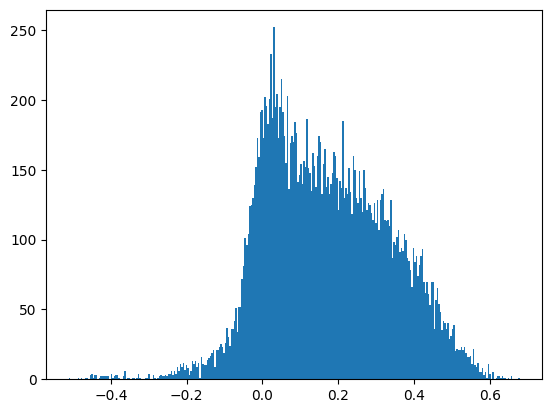

In [16]:
plt.hist(old_tpm_correlation_list, bins=300)

# Quantile Normalization

In [17]:
raw_tpm_copy = raw_tpm.copy().T

In [18]:
def quant_norm1(df):
    ranks = (df.rank(method="first")
              .stack())
    rank_mean = (df.stack()
                   .groupby(ranks)
                   .mean())
    print(rank_mean.head())
    print(rank_mean.tail())

    return (df.rank(method='min')
             .stack()
             .astype(int)
             .map(rank_mean)
             .unstack())

In [19]:
def quant_norm2(df):
    ranks = (df.rank(method="first")
              .stack())
    rank_mean = (df.stack()
                   .groupby(ranks)
                   .mean())
    print(rank_mean.head())
    print(rank_mean.tail())

    # Add interpolated values in between ranks
    finer_ranks = ((rank_mean.index+0.5).to_list() +
                    rank_mean.index.to_list())
    print(len(finer_ranks))
    print(len(finer_ranks))

    rank_mean = rank_mean.reindex(finer_ranks).sort_index().interpolate()
    print(rank_mean.head())
    print(rank_mean.tail())
    return (df.rank(method='average')
              .stack()
              .map(rank_mean)
              .unstack())

In [20]:
raw_tpm_copy = quant_norm1(raw_tpm_copy)

1.0    0.0
2.0    0.0
3.0    0.0
4.0    0.0
5.0    0.0
dtype: float64
19189.0    16347.327426
19190.0    18496.411635
19191.0    21248.354106
19192.0    25916.754038
19193.0    47241.614074
dtype: float64


In [21]:
raw_tpm_copy = quant_norm2(raw_tpm_copy)

1.0    0.0
2.0    0.0
3.0    0.0
4.0    0.0
5.0    0.0
dtype: float64
19189.0    16347.327426
19190.0    18496.411635
19191.0    21248.354106
19192.0    25916.754038
19193.0    47241.614074
dtype: float64
38386
38386
1.0    0.0
1.5    0.0
2.0    0.0
2.5    0.0
3.0    0.0
dtype: float64
19191.5    23582.554072
19192.0    25916.754038
19192.5    36579.184056
19193.0    47241.614074
19193.5    47241.614074
dtype: float64


In [22]:
raw_tpm_copy = raw_tpm_copy.T

In [23]:
raw_tpm_copy.head()

,TSPAN6 (7105),TNMD (64102),DPM1 (8813),SCYL3 (57147),C1orf112 (55732),FGR (2268),CFH (3075),FUCA2 (2519),GCLC (2729),NFYA (4800),...,H3C2 (8358),H3C3 (8352),AC098582.1 (8916),DUS4L-BCAP29 (115253422),C8orf44-SGK3 (100533105),ELOA3B (728929),NPBWR1 (2831),ELOA3D (100506888),ELOA3 (162699),CDR1 (1038)
ACH-001113,17.416861,6.573818e-08,159.931814,5.158212,19.332535,1.284990e-02,1.058297,6.305254,88.032396,23.905696,...,4.807608,0.092853,0.100984,2.839342,0.351003,6.573818e-08,0.151341,6.573818e-08,6.573818e-08,6.573818e-08
ACH-001289,21.398286,5.556133e-01,117.522439,4.786895,9.938277,6.847798e-08,0.156412,12.450694,16.719879,9.792638,...,1.504714,1.152850,0.278714,1.812299,0.606533,6.847798e-08,0.012020,6.847798e-08,6.847798e-08,6.847798e-08
ACH-001339,9.076940,2.915042e-08,152.998605,4.643071,19.728055,3.021006e-02,1.817990,97.476120,13.364847,9.905601,...,0.624039,1.391007,0.958444,7.697868,0.469390,2.915042e-08,0.055497,2.915042e-08,2.915042e-08,2.446859e-02
ACH-001979,23.363881,1.309268e-05,60.591167,5.066298,3.636843,1.309268e-05,161.769723,71.508057,29.610335,9.312575,...,0.000013,0.000013,1.785865,4.444425,0.404807,1.309268e-05,0.043123,1.309268e-05,1.309268e-05,1.309268e-05
ACH-002438,16.642057,2.541201e-06,97.330763,3.511508,7.582847,2.541201e-06,3.686213,107.925560,9.365751,20.012370,...,0.246219,0.387612,0.603535,2.453337,0.906495,2.541201e-06,0.033463,2.541201e-06,2.541201e-06,6.040966e-02


In [24]:
old_mean_exp = raw_tpm_copy.median(axis=1)

old_tpm_correlation_list = []
for gene in raw_tpm_copy.columns:
    old_tpm_correlation_list.append(pearsonr(old_mean_exp, raw_tpm_copy.loc[:, gene])[0])

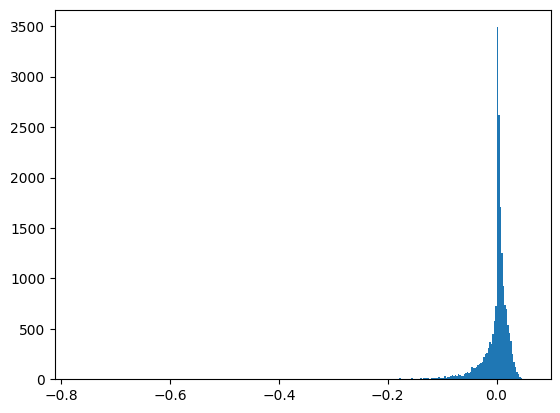

In [25]:
_ = plt.hist(old_tpm_correlation_list, bins=300)

In [26]:
patterns = []
amplitudes = []
for norm_gene_expression in [np.sqrt(raw_tpm_copy)]:
    ica_model = FastICA(n_components=100,
                        random_state=99,
                        whiten='unit-variance')

    #nmf_model = NMF(n_components=100, init='random',
    #                random_state=99)

    #pca_model = PCA(n_components=100,
    #                random_state=99,
    #                whiten=True)

    ica_X_transformed = ica_model.fit_transform(norm_gene_expression)
    A = ica_model.mixing_

    patterns.append(ica_X_transformed)
    amplitudes.append(A)

    #W = nmf_model.fit_transform(norm_gene_expression)
    #H = nmf_model.components_
    #patterns.append(W)
    #amplitudes.append(H)

    #pattern = pca_model.fit_transform(norm_gene_expression)
    #amplitude = pca_model.components_
    #patterns.append(pattern)
    #amplitudes.append(amplitude)
    ##break

In [27]:
ica_X_transformed.shape

(1882, 100)

In [28]:
import pandas as pd
model_dataset = pd.read_csv("~/23Q4_model.csv", index_col=0)

In [29]:
patterns[0].shape

(1882, 100)

/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_6076/3582590971.py:15: UserWarning: 
The palette list has fewer values (25) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(pat_df, x="x", y="y", hue='lineage', ax=ax[n],
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_6076/3582590971.py:15: UserWarning: 
The palette list has fewer values (25) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(pat_df, x="x", y="y", hue='lineage', ax=ax[n],
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_6076/3582590971.py:15: UserWarning: 
The palette list has fewer values (25) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(pat_df, x="x", y="y", hue='lineage', ax=ax[n],
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_6076/3582590971.py:15: UserWarning: 
The palette list has fewer values (25) than needed (33) and will cycle, which may produc

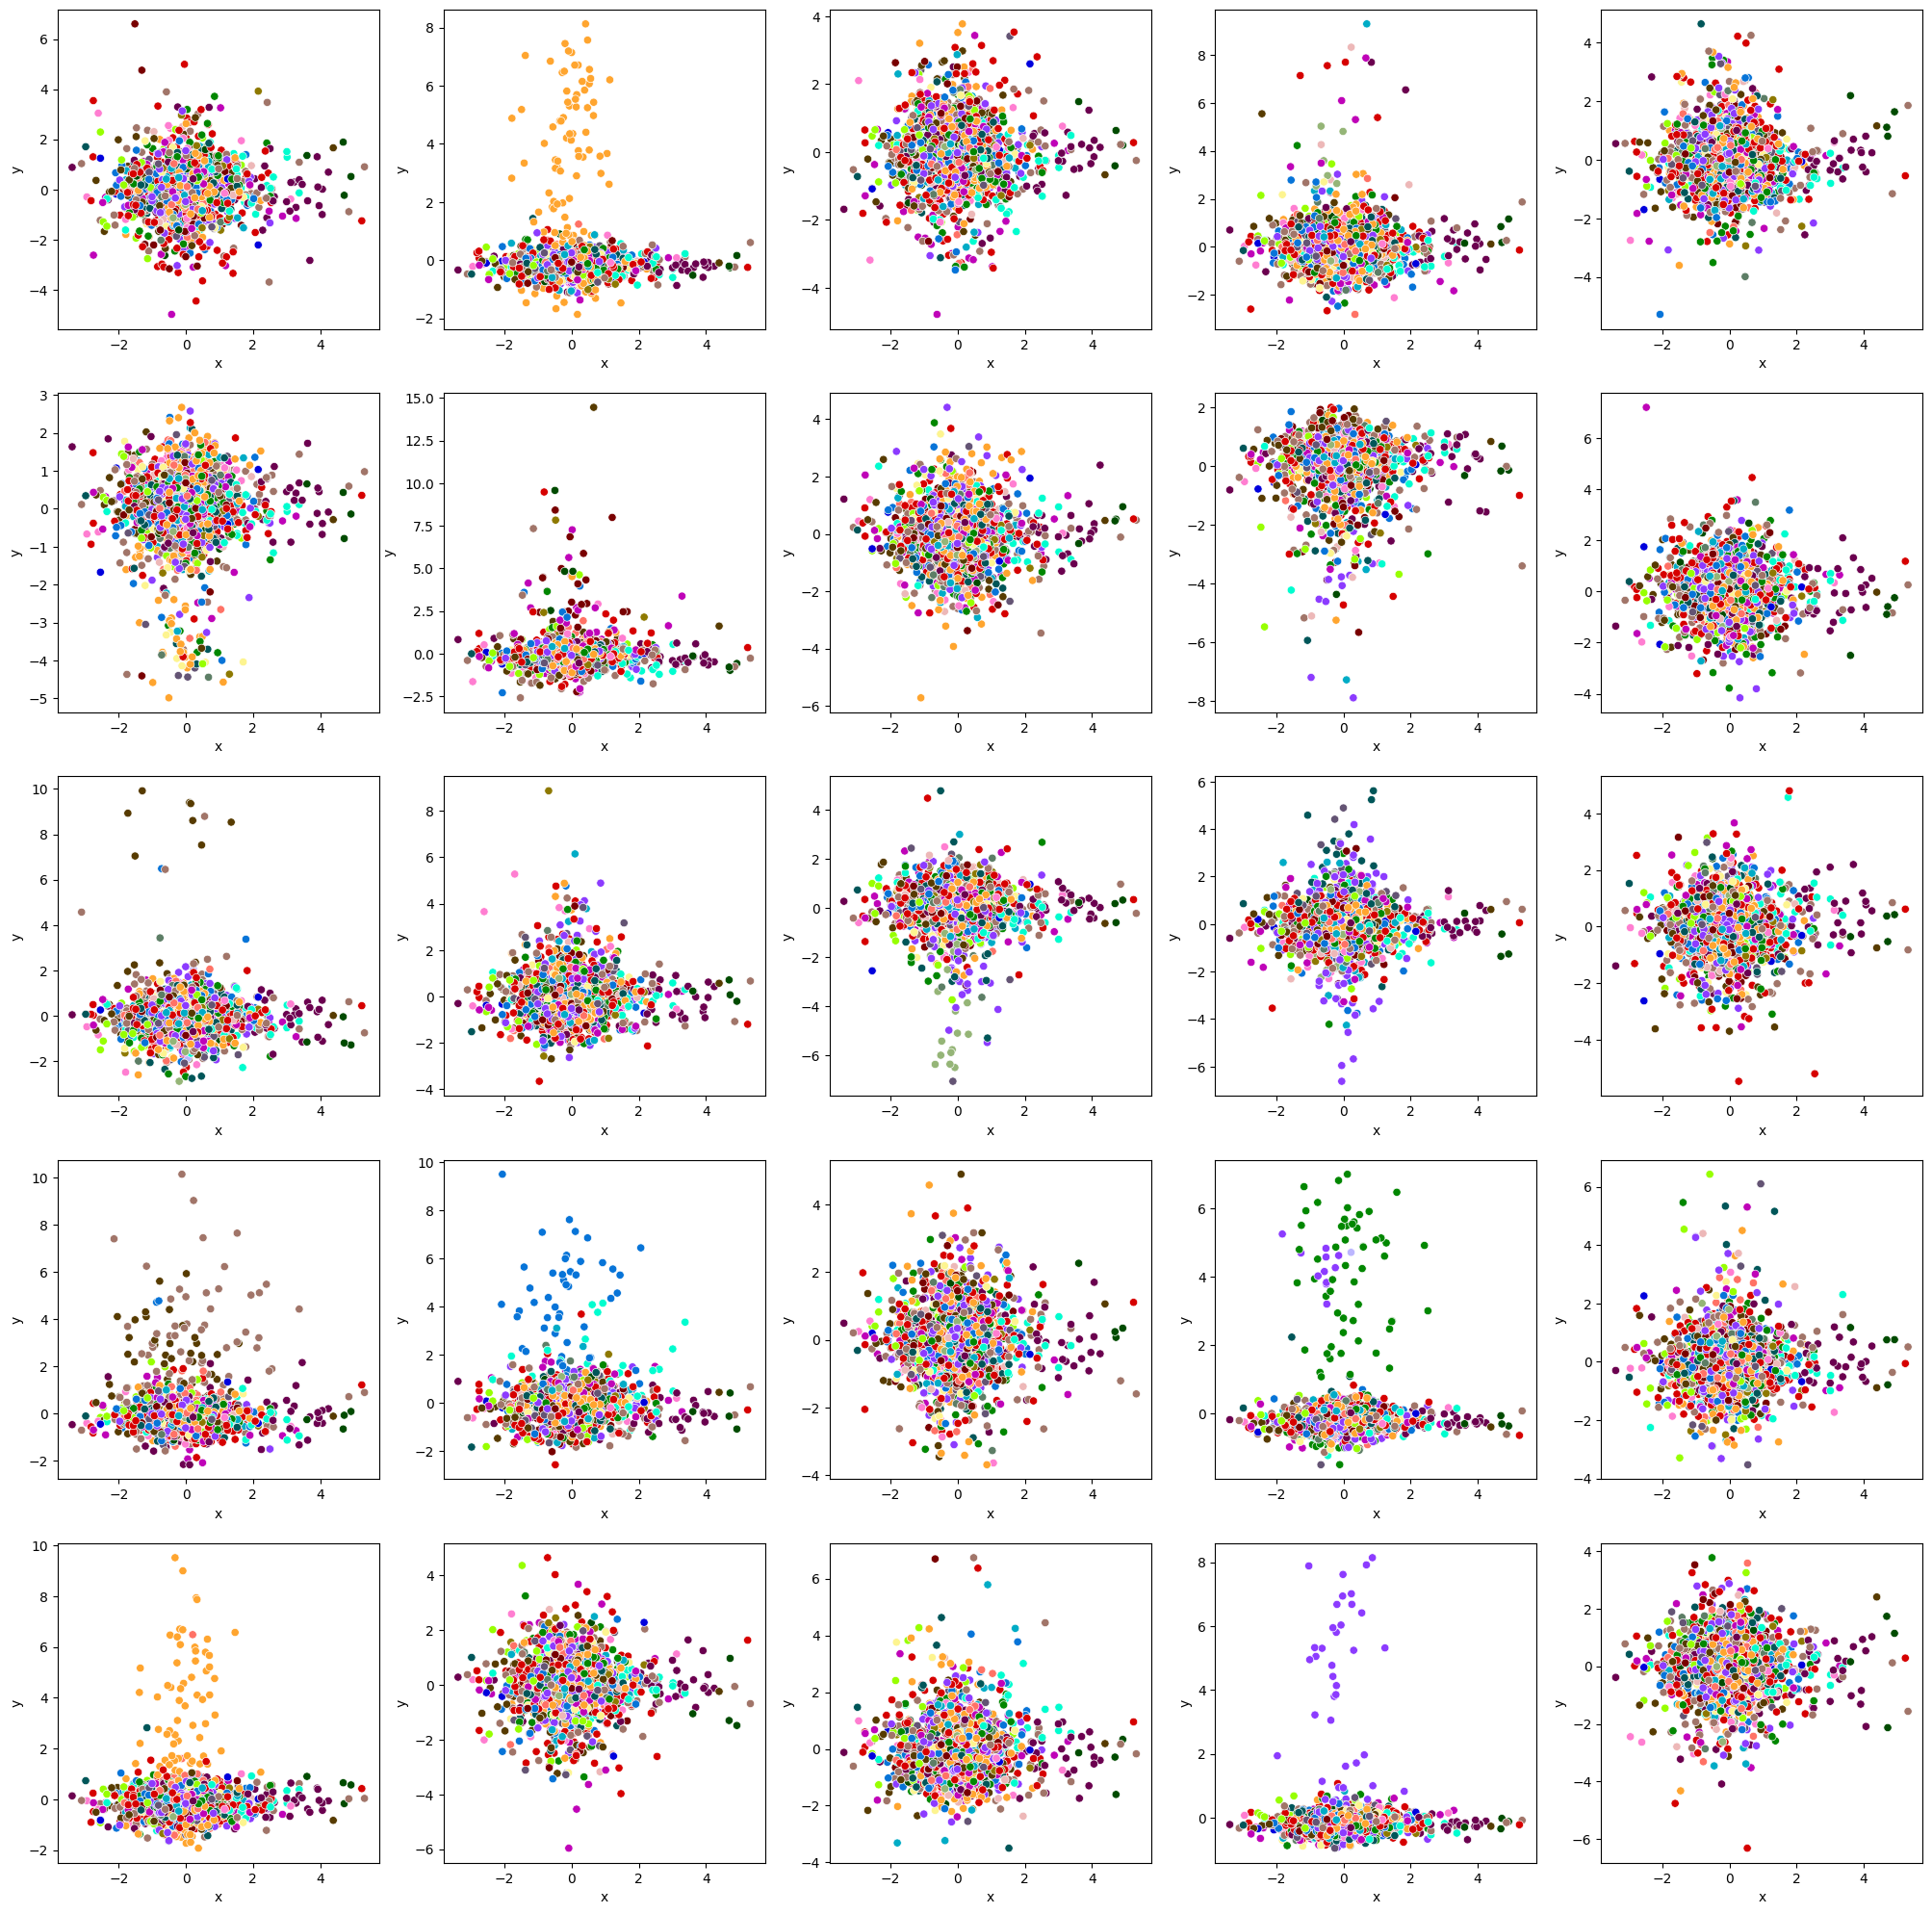

In [30]:
import colorcet as cc
palette = sns.color_palette(cc.glasbey, n_colors=25)

pat = patterns[0]

fig, ax = plt.subplots(5, 5)
fig.set_size_inches(25, 25)
ax = ax.flatten()
n = 0
for i in range(100):
    for j in range(100):
        if i != j:
            if n > 24: break
            pat_df = pd.DataFrame(dict(x=pat[:,i], y=pat[:,j], lineage=raw_tpm_copy.index.map(model_dataset.OncotreeLineage.to_dict())))
            sns.scatterplot(pat_df, x="x", y="y", hue='lineage', ax=ax[n],
                            palette=palette, legend=False)
            n += 1

In [31]:
pat_df = pd.DataFrame(pat, columns=np.arange(100))
pat_df.loc[:, "lineage"] = raw_tpm_copy.index.map(model_dataset.OncotreeLineage.to_dict())

In [32]:
pat_df = pat_df.set_index("lineage")

/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_6076/3760337469.py:4: UserWarning: 
The palette list has fewer values (25) than needed (33) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(data=pat_df.melt(ignore_index=False).reset_index(),


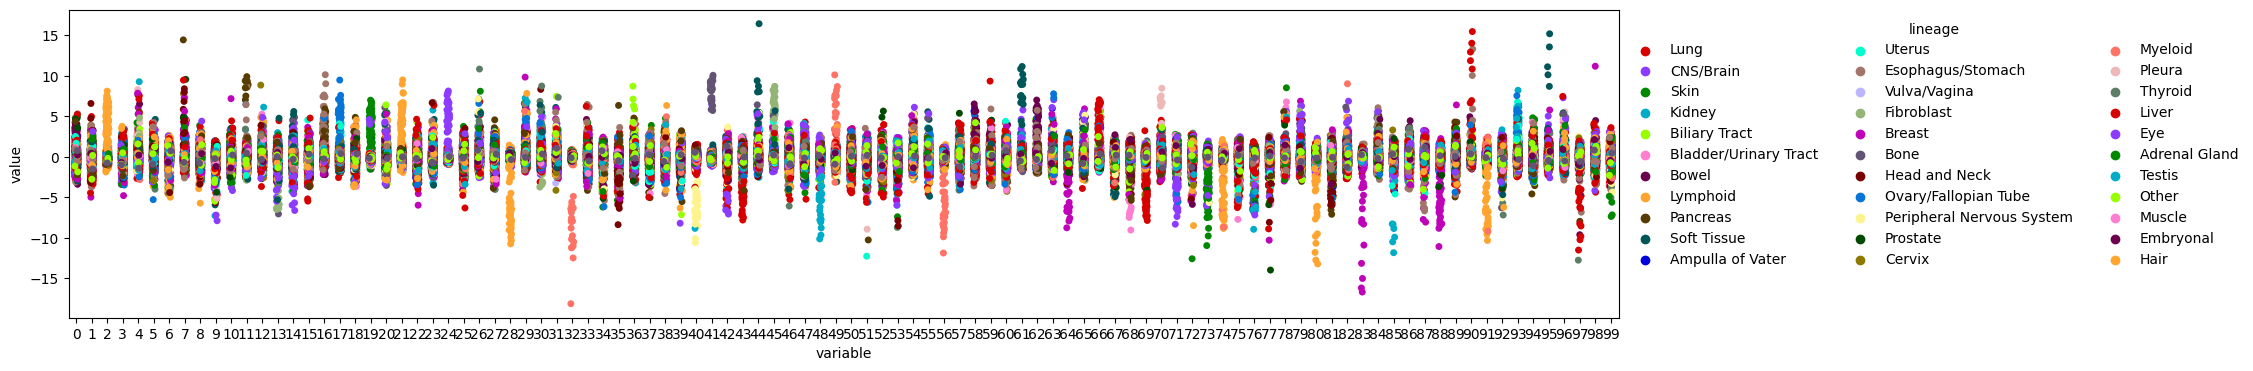

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 4)

sns.stripplot(data=pat_df.melt(ignore_index=False).reset_index(), 
              legend='brief', hue='lineage', x='variable', y='value', 
              palette=palette, ax=ax)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), 
                frameon=False, ncols=3)